In [26]:
import pandas as pd
import numpy as np
import plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, plot
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import feather
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, preprocessing


import seaborn as sns

#df = pd.read_csv(r"C:\Users\Joaquin\Dropbox\feather\properati_final.csv")
df = feather.read_dataframe(r"E:\Dropbox\feather\principal.feather") 
#localidades = feather.read_dataframe(r"E:\Dropbox\feather\localidades.feather") 
#partidos = feather.read_dataframe(r"E:\Dropbox\feather\partidos.feather") 
provincias = feather.read_dataframe(r"E:\Dropbox\feather\provincias.feather") 

#provincias 5 = capital federal


In [27]:
#segmento el modelo especificamente para CAPITAL FEDERAL

mask_caba = df['provincia'] == 5.0
df = df[mask_caba]


In [28]:
#selecciono mi grupo de variables para el modelo
variables_independientes=['price_aprox_usd','surface_covered_in_m2','ambientes','property_type']

#armo la matriz con mis variables seleccionadas de estudio predictoras
subdf=df[variables_independientes]

#dropeamos filas que tengan algun registro NaN
datos = subdf.dropna(axis=0, how='any', inplace=False)

#genero dummies sobre las variables categoricas

datos2 = pd.get_dummies(datos, columns = ["property_type", ], drop_first = True)


       
# #separo la variable price y la dropeo de la matrix de explicativas
price=datos2.price_aprox_usd
x= datos2.drop(columns=['price_aprox_usd'])
informacion = datos2.drop(columns=['price_aprox_usd'])




In [29]:
print('shape datos',datos.shape)
print('shape df datos con dummies',datos2.shape)
print('valores unicos property type', datos.property_type.nunique())

#esperaba que las columnas de datos2 sean igual a 18 + 566 - 2 


shape datos (22616, 4)
shape df datos con dummies (22616, 6)
valores unicos property type 4


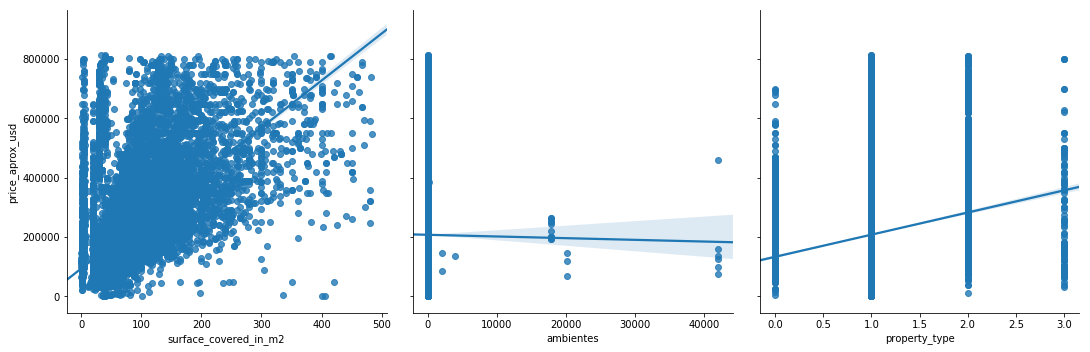

In [30]:
vars_graph=['surface_covered_in_m2','ambientes','property_type']

sns.pairplot(datos, x_vars=vars_graph, y_vars='price_aprox_usd', kind='reg',\
                                                height=5, aspect=1);

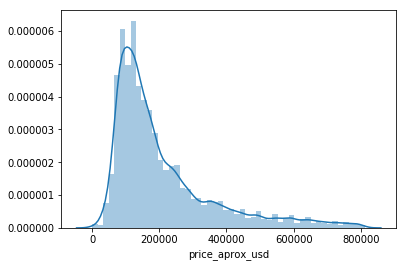

In [31]:
sns.distplot(datos['price_aprox_usd']) 

In [32]:
print ("no encontramos multicolinealidad alta en ningun caso")
x.corr()


no encontramos multicolinealidad alta en ningun caso


,surface_covered_in_m2,ambientes,property_type_1,property_type_2,property_type_3
surface_covered_in_m2,1.000000,0.000654,-0.362960,0.451718,0.037266
ambientes,0.000654,1.000000,0.010981,-0.006810,-0.002024
property_type_1,-0.362960,0.010981,1.000000,-0.627598,-0.172873
property_type_2,0.451718,-0.006810,-0.627598,1.000000,-0.016772
property_type_3,0.037266,-0.002024,-0.172873,-0.016772,1.000000


In [33]:
#estudiamos VIF

import statsmodels.stats.outliers_influence as oi

for i in range(len(x.columns)):
    vif_col = oi.variance_inflation_factor(np.matrix(x), i)
    print('columna ' + str(i) + " " + str(vif_col))
    
print ("el indicador de inflación de varianca da dentro de parámetros normales")

columna 0 2.6873424617508412
columna 1 1.001225981263544
columna 2 2.098066615908461
columna 3 1.5744967107397583
columna 4 1.01555649789617
el indicador de inflación de varianca da dentro de parámetros normales


In [34]:
#calculo un modelo lineal para estudiar los residuos
import statsmodels.api as sm

X = x
Y = price

X_intercept = sm.add_constant(X)

# Fit and summarize OLS model
model_intercept = sm.OLS(Y, X_intercept)
model_intercept = model_intercept.fit()
print (model_intercept.summary())
predictions_intercept = model_intercept.predict(X_intercept)

print()
print("COMENTARIOS")
print("1-Con un r2 del 37.5%, la explicatividad del modelo específicamente para CABA mejora respecto al caso general ")
print("2-los TSI para todas las variables dan significativas, excepto para ambientes")
print("3-obtenemos un mensaje de alerta por presencia de multicolinealidad en la matriz de datos, que no percibimos en el VIF o en la matriz de correlación, pero lo buscaremos solucionar con regularización más adelante")

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     2719.
Date:                Mon, 08 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:27:15   Log-Likelihood:            -2.9662e+05
No. Observations:               22616   AIC:                         5.933e+05
Df Residuals:                   22610   BIC:                         5.933e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.544e+

media del resiudo metodo 1 3.8920849993914565e-08
media del resiudo metodo 2 3.895060240637299e-08

COMENTARIOS
La media del residuo es cero, cumplimos el supuesto 4 de GM


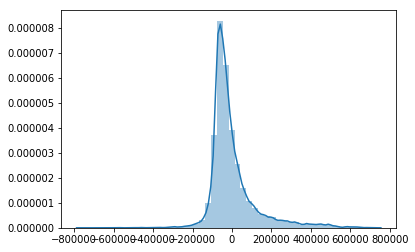

In [35]:
Y = pd.DataFrame(Y)


predictions_intercept_df = pd.DataFrame(predictions_intercept)
residuos_intercept = Y.values - predictions_intercept_df.values
print("media del resiudo metodo 1", residuos_intercept.mean())


print("media del resiudo metodo 2",model_intercept.resid.mean())

sns.distplot(residuos_intercept)


print()
print("COMENTARIOS")
print("La media del residuo es cero, cumplimos el supuesto 4 de GM")

el comportamiento del residuo se modifica para distintos valores de la variable, heterosedasticidad.


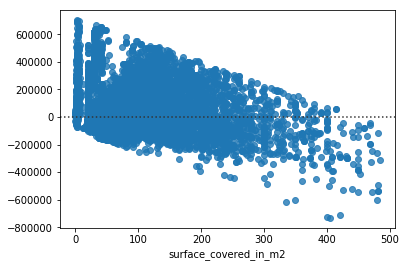

In [36]:
sns.residplot(X['surface_covered_in_m2'], Y)
print("el comportamiento del residuo se modifica para distintos valores de la variable, heterosedasticidad.")

lo mismo que el caso anterior


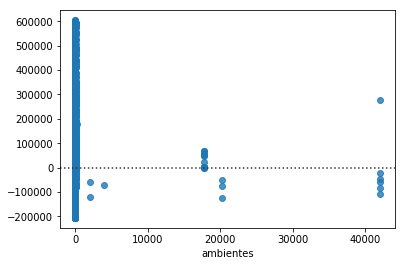

In [37]:
sns.residplot(X['ambientes'], Y)
print("lo mismo que el caso anterior")

In [38]:
import statsmodels.stats.api as sms

resids_standardized = model_intercept.get_influence().resid_studentized_internal

resids = model_intercept.resid

bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model_intercept.model.exog), 
                       columns=['value'],
                       index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])


gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model_intercept.model.exog)[:-1],
                       columns=['value'],
                       index=['F statistic', 'p-value'])



print('\n Breusch-Pagan test ----')
print(bp_test)
print('\n Goldfeld-Quandt test ----')
print(gq_test)


print()
print("COMENTARIOS")
print("Breusch-Pagan test, no rechazo H0, existe homosedasticidad / varianza constante del error ")
print("Goldfeld-Quandt test no rechazo H0, existe homosedasticidad / varianza constante del error")



 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  3.858562e+02
p-value                        3.313043e-81
f-value                        7.848989e+01
f p-value                      6.599273e-82

 Goldfeld-Quandt test ----
                value
F statistic  0.582898
p-value      1.000000

COMENTARIOS
Breusch-Pagan test, no rechazo H0, existe homosedasticidad / varianza constante del error 
Goldfeld-Quandt test no rechazo H0, existe homosedasticidad / varianza constante del error


In [39]:
print (sms.het_white(resids, model_intercept.model.exog, retres=False))
print("test de white, rechaza H0, no hay homosedasticidad")

(1517.8795376438136, 0.0, 116.1430316963094, 0.0)
test de white, rechaza H0, no hay homosedasticidad



COMENTARIOS
el comportamiento del residuo varia para distintos valores de la variable. La línea no es horizontal. Heterosedasticidad


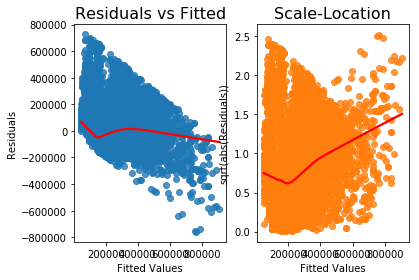

In [40]:
fig, ax = plt.subplots(1,2)

fitted_vals = predictions_intercept

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Residuals vs Fitted', fontsize=16)
ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Scale-Location', fontsize=16)
ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')


print()
print("COMENTARIOS")
print("el comportamiento del residuo varia para distintos valores de la variable. La línea no es horizontal. Heterosedasticidad")


Jarque-Bera test ---- statistic: 53842.0133, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.7854, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.6734, p-value: 0.0000
Anderson-Darling test ---- statistic: 1528.2781, 5% critical value: 0.7870
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 

COMENTARIOS
rechazo hipotesis nula en JB, Shapiro, Kolmogorov y no rechazo Anderson - Darling
no puedo probar que los residuos tengan una distribución normal
En Q-Q plot no tengo una correcta coincidencia de los valores sobre la lína. Los quantiles de la distribución normal no coinciden con los cuantiles de la distribución del error, por lo tanto, no se comporta como una normal


C:\Users\QQ-Haum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning:

p-value may not be accurate for N > 5000.



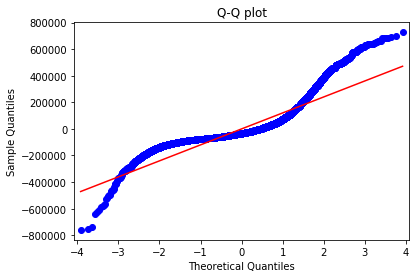

In [41]:
from scipy import stats
sm.ProbPlot(model_intercept.resid).qqplot(line='s');
plt.title('Q-Q plot');

jb = stats.jarque_bera(model_intercept.resid)
sw = stats.shapiro(model_intercept.resid)
ad = stats.anderson(model_intercept.resid, dist='norm')
ks = stats.kstest(model_intercept.resid, 'norm')

print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')


print()
print("COMENTARIOS")
print("rechazo hipotesis nula en JB, Shapiro, Kolmogorov y no rechazo Anderson - Darling")
print("no puedo probar que los residuos tengan una distribución normal")
print("En Q-Q plot no tengo una correcta coincidencia de los valores sobre la lína. Los quantiles de la distribución normal no coinciden con los cuantiles de la distribución del error, por lo tanto, no se comporta como una normal")


In [42]:

print('r2: ' + str(model_intercept.rsquared))

rss = np.sum(model_intercept.resid**2)
print('rss: ' + str(rss))
#rmse(Y,)


r2: 0.375487848223767
rss: 326595346950539.06


C:\Users\QQ-Haum\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.

C:\Users\QQ-Haum\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning:

Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.



-2.524228222584971e-16 media de variable ambientes
1.0000442184392124 varianza de variable ambientes
-6.760843899029468e-16 media de variable surface covered
1.0000442184391256 varianza de variable surface covered
1.0024799447504088e-14 media de variable property_type_1
1.0000442184392433 varianza de variable property_type_1

normalizacion exitosa, vemos histogramas de las variables a continuación:


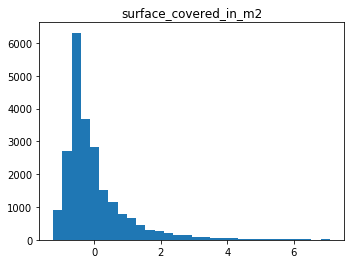

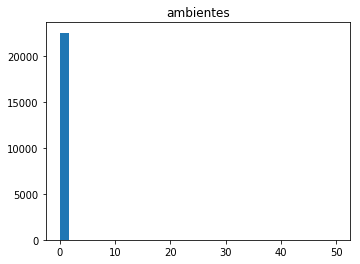

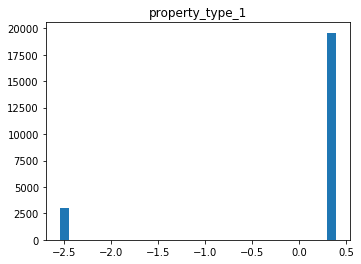

In [43]:
#ANTES DE PASAR A REGULARIZACIÓN, VOY A APLICAR STANDARD SCALER A LA MATRIZ DE DATOS Y EVALUAR SI PRESENTO UNA MEJORA
# SIGNIFICATIVA RESPECTO DEL MODELO SIN NORMALIZACIÓN
x= datos2.drop(columns=['price_aprox_usd'])

#CORRO STANDARD SCALER Y NO MIN MAX, YA QUE ESTE ÚLTIMO NO RESOLVIÓ LOS PROBLEMAS EN EL COMPORTAMIENTO DEL ERROR

from sklearn import datasets, preprocessing


stdscaler = preprocessing.StandardScaler()
x = stdscaler.fit_transform(x)

x = pd.DataFrame(x)
x.columns = informacion.columns


#Verificamos el histógrama de las variables reescaladas

plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax1.set_title("surface_covered_in_m2")
ax1.hist(x["surface_covered_in_m2"],bins=30);

plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax1.set_title("ambientes")
ax1.hist(x["ambientes"],bins=30);

plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax1.set_title("property_type_1")
ax1.hist(x["property_type_1"],bins=30);

print (x.ambientes.mean(), "media de variable ambientes")
print (x.ambientes.var(), "varianza de variable ambientes")

print (x.surface_covered_in_m2.mean(), "media de variable surface covered")
print (x.surface_covered_in_m2.var(), "varianza de variable surface covered")

print (x.property_type_1.mean(), "media de variable property_type_1")
print (x.property_type_1.var(), "varianza de variable property_type_1")

print()
print("normalizacion exitosa, vemos histogramas de las variables a continuación:")



SEGUIMOS CON REGULARIZACION

In [45]:
X_intercept = sm.add_constant(x)
y=price

#SETEAMOS UN CONJUNTO PARA TRAIN Y OTRO PARA TEST



X_train, X_test, y_train, y_test = train_test_split(X_intercept, y, test_size=0.30)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15831, 6) (15831,)
(6785, 6) (6785,)


In [46]:
kf = KFold(n_splits=5, shuffle=True)

In [ ]:
#REGRESIÓN LINEAL

In [78]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)
y = y_test
y_pred = lm.predict(X_test)
rmse_lineal = np.sqrt(mean_squared_error(y, y_pred))
rmse_lineal


linealpredict = lm.predict(X_test)
rmselienal = np.sqrt(mean_squared_error(y_test, linealpredict))
scorelineal = lm.score(X_test, y_test)
print (rmselienal)
print (scorelineal)

119683.47492775513
0.3631316059503408


In [49]:
#RIDGE

alfas_ridge = np.linspace(0.001, 0.3, 300)
lm_ridge_cv= RidgeCV(alphas=alfas_ridge, cv=kf, normalize=False, fit_intercept = True)
lm_ridge_cv.fit(X_train, y_train)
print('Alpha Ridge:', lm_ridge_cv.alpha_)   

y = y_train
model = Ridge(lm_ridge_cv.alpha_, normalize=False, fit_intercept = True)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
np.sqrt(mean_squared_error(y, y_pred))


Alpha Ridge: 0.3


120421.57709716196

In [50]:
#LASSO

alfas_lasso = np.linspace(0.1, 0.5, 300)
lm_lasso_cv = LassoCV(alphas=alfas_lasso, cv=kf, normalize=False, fit_intercept = True)
lm_lasso_cv.fit(X_train, y_train)
print('Alpha LASSO:', lm_lasso_cv.alpha_)

y = y_train
model = Ridge(lm_lasso_cv.alpha_, normalize=False, fit_intercept = True)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
np.sqrt(mean_squared_error(y, y_pred))

Alpha LASSO: 0.48929765886287635


120421.57713099409

In [70]:
#con los ALPHAs de Ridge y Lasso voy a armar los 2 modelos sobre el conjunto test y obtener los coeficientes
#BETA para cada variable del modelo


alpha_LASSO = 0.489
error_train_LASSO = 120421

model_lasso = Lasso(alpha_LASSO, fit_intercept=True, normalize=False)
model_lasso.fit(X_train, y_train)
y_pred_cv_sklearn1 = model_lasso.predict(X_test)
rmse_cv_sklearnlasso = np.sqrt(mean_squared_error(y_test, y_pred_cv_sklearn1))
score_cv_sklearnlasso = model_lasso.score(X_test, y_test)
print(rmse_cv_sklearnlasso)
print(score_cv_sklearnlasso)


alpha_RIDGE = 0.3
error_train_RIDGE = 120421

model_cv_sklearn = Ridge(alpha_RIDGE, fit_intercept=True, normalize=False)
model_cv_sklearn.fit(X_train, y_train)
y_pred_cv_sklearn2 = model_cv_sklearn.predict(X_test)
rmse_cv_sklearnridge = np.sqrt(mean_squared_error(y_test, y_pred_cv_sklearn2))
score_cv_sklearnridge = model_cv_sklearn.score(X_test, y_test)
print(rmse_cv_sklearnridge)
print(score_cv_sklearnridge)


119683.45720421139
0.3631317945739416
119683.33126098041
0.36313313492956245


In [82]:

print (rmselienal, "error regresion lineal sin regularizacion")
print (scorelineal, "R2 regresion lineal sin regularizacion")
print ()
print(rmse_cv_sklearnlasso, "error metodo Lasso")
print(score_cv_sklearnlasso, "R2 metodo Lasso")
print ()
print(rmse_cv_sklearnridge, "error metodo Ridge")
print(score_cv_sklearnridge, "R2 metodo Ridge")
print()
print("todos los metodos dan un R2 y en error casi identico")

119683.47492775513 error regresion lineal sin regularizacion
0.3631316059503408 R2 regresion lineal sin regularizacion

119683.45720421139 error metodo Lasso
0.3631317945739416 R2 metodo Lasso

119683.33126098041 error metodo Ridge
0.36313313492956245 R2 metodo Ridge

todos los metodos dan un R2 y en error casi identico


In [80]:
#vemos los coeficientes

coeficientes = pd.DataFrame()
coeficientes['Linear'] = lm.coef_
coeficientes['Ridge'] = model_cv_sklearn.coef_
coeficientes['Lasso'] = model_lasso.coef_
coeficientes


,Linear,Ridge,Lasso
0,0.000000,0.000000,0.000000
1,98664.438042,98661.982288,98664.261111
2,-923.467308,-923.437352,-923.020451
3,17130.495214,17129.513563,17129.907241
4,2820.353153,2820.811863,2819.555007
5,5553.422354,5553.209782,5552.748793
